In [1]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.patches import Circle, ConnectionPatch, Rectangle
import matplotlib.animation as animation
from numpy.lib.stride_tricks import sliding_window_view
from scipy import integrate, spatial

from utils.plot.utils import plot_cobweb, get_iterative_map_results, plot_orbit_diagram

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 12 - Strange Attractors

The basic mechanism for strange attractors is squashing (due to dissipation) and folding

## Baker's Map
$$
B(x, y) = \begin{cases}
(2x, ay) & \text{for } x \leq \frac{1}{2}, \\
(2x - 1, ay + \frac{1}{2}) & \text{otherwise}.
\end{cases}
$$
With $a \in \mathbb{R}$, $0 < a < \frac{1}{2}$ and $B: [0, 1]^2 \to [0, 1]^2$

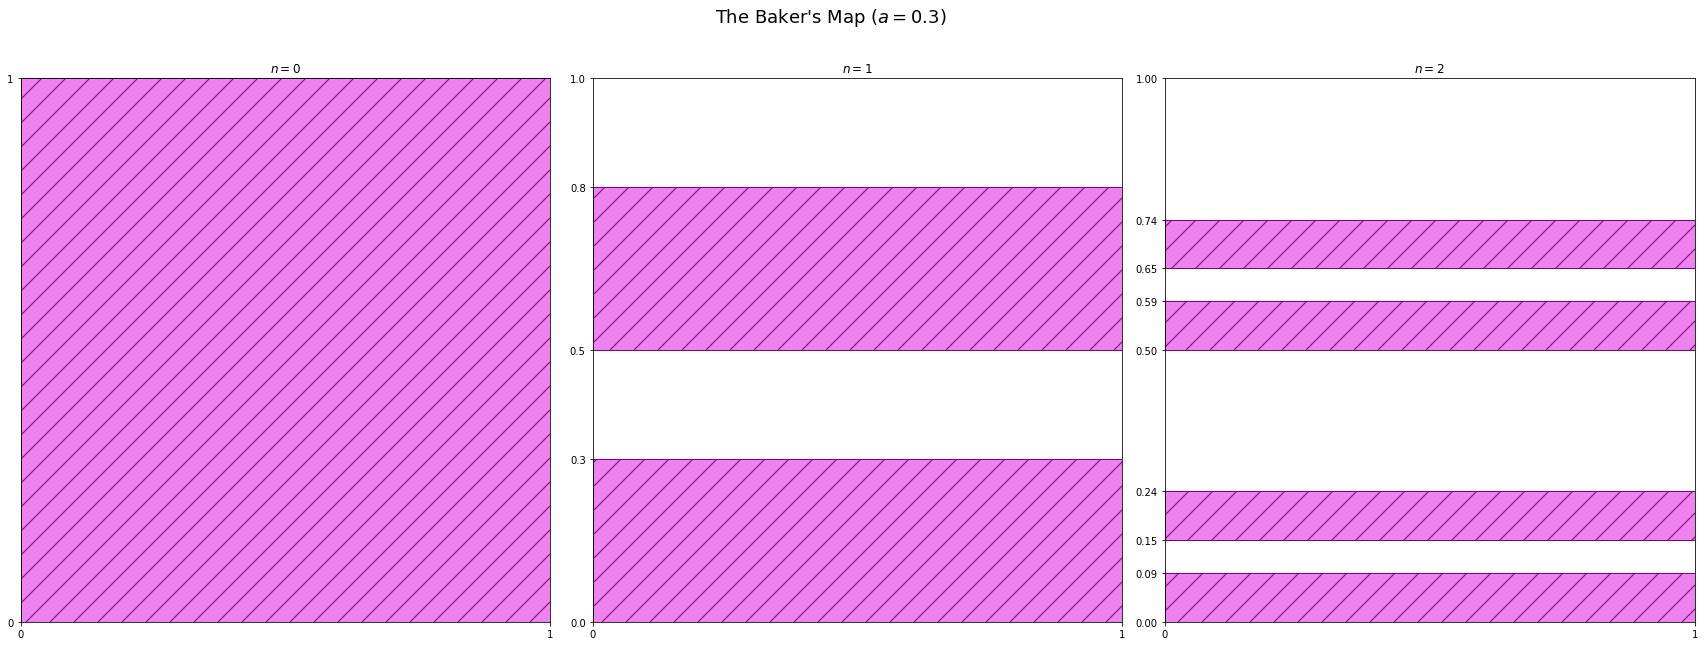

In [67]:
a = .3
fig = plt.figure(figsize=(30, 10))
fig.suptitle("The Baker's Map ($a = 0.3$)", fontsize=18)
axA, axB, axC = fig.subplots(1, 3, gridspec_kw=dict({ "wspace": .08 }), subplot_kw=dict({ "xticks": [0, 1], "xlim": [0, 1], "ylim": [0, 1] }))

axA.set_title("$n = 0$")
axA.add_patch(Rectangle([0, 0], 1, 1, facecolor="violet", edgecolor="purple", hatch="/"))
axA.set_yticks([0, 1])

axB.set_title("$n = 1$")
axB.add_patch(Rectangle([0, 0], 1, a, facecolor="violet", edgecolor="purple", hatch="/"))
axB.add_patch(Rectangle([0, 1/2], 1, a, facecolor="violet", edgecolor="purple", hatch="/"))
axB.set_yticks([0, a, 1/2, 1/2 + a, 1])

axC.set_title("$n = 2$")
axC.add_patch(Rectangle([0, 0], 1, a**2, facecolor="violet", edgecolor="purple", hatch="/"))
axC.add_patch(Rectangle([0, a/2], 1, a**2, facecolor="violet", edgecolor="purple", hatch="/"))
axC.add_patch(Rectangle([0, 1/2], 1, a**2, facecolor="violet", edgecolor="purple", hatch="/"))
axC.add_patch(Rectangle([0, 1/2 + a/2], 1, a**2, facecolor="violet", edgecolor="purple", hatch="/"))
axC.set_yticks([0, a**2, a/2, a/2 + a**2, 1/2, 1/2 + a**2, 1/2 + a/2, 1/2 + a/2 + a**2, 1])

plt.show()

## Hénon Map
$$
\begin{align*}
x_{n + 1} &= y_n + 1 - ax_n^2 \\
y_{n + 1} &= bx_n
\end{align*}
$$

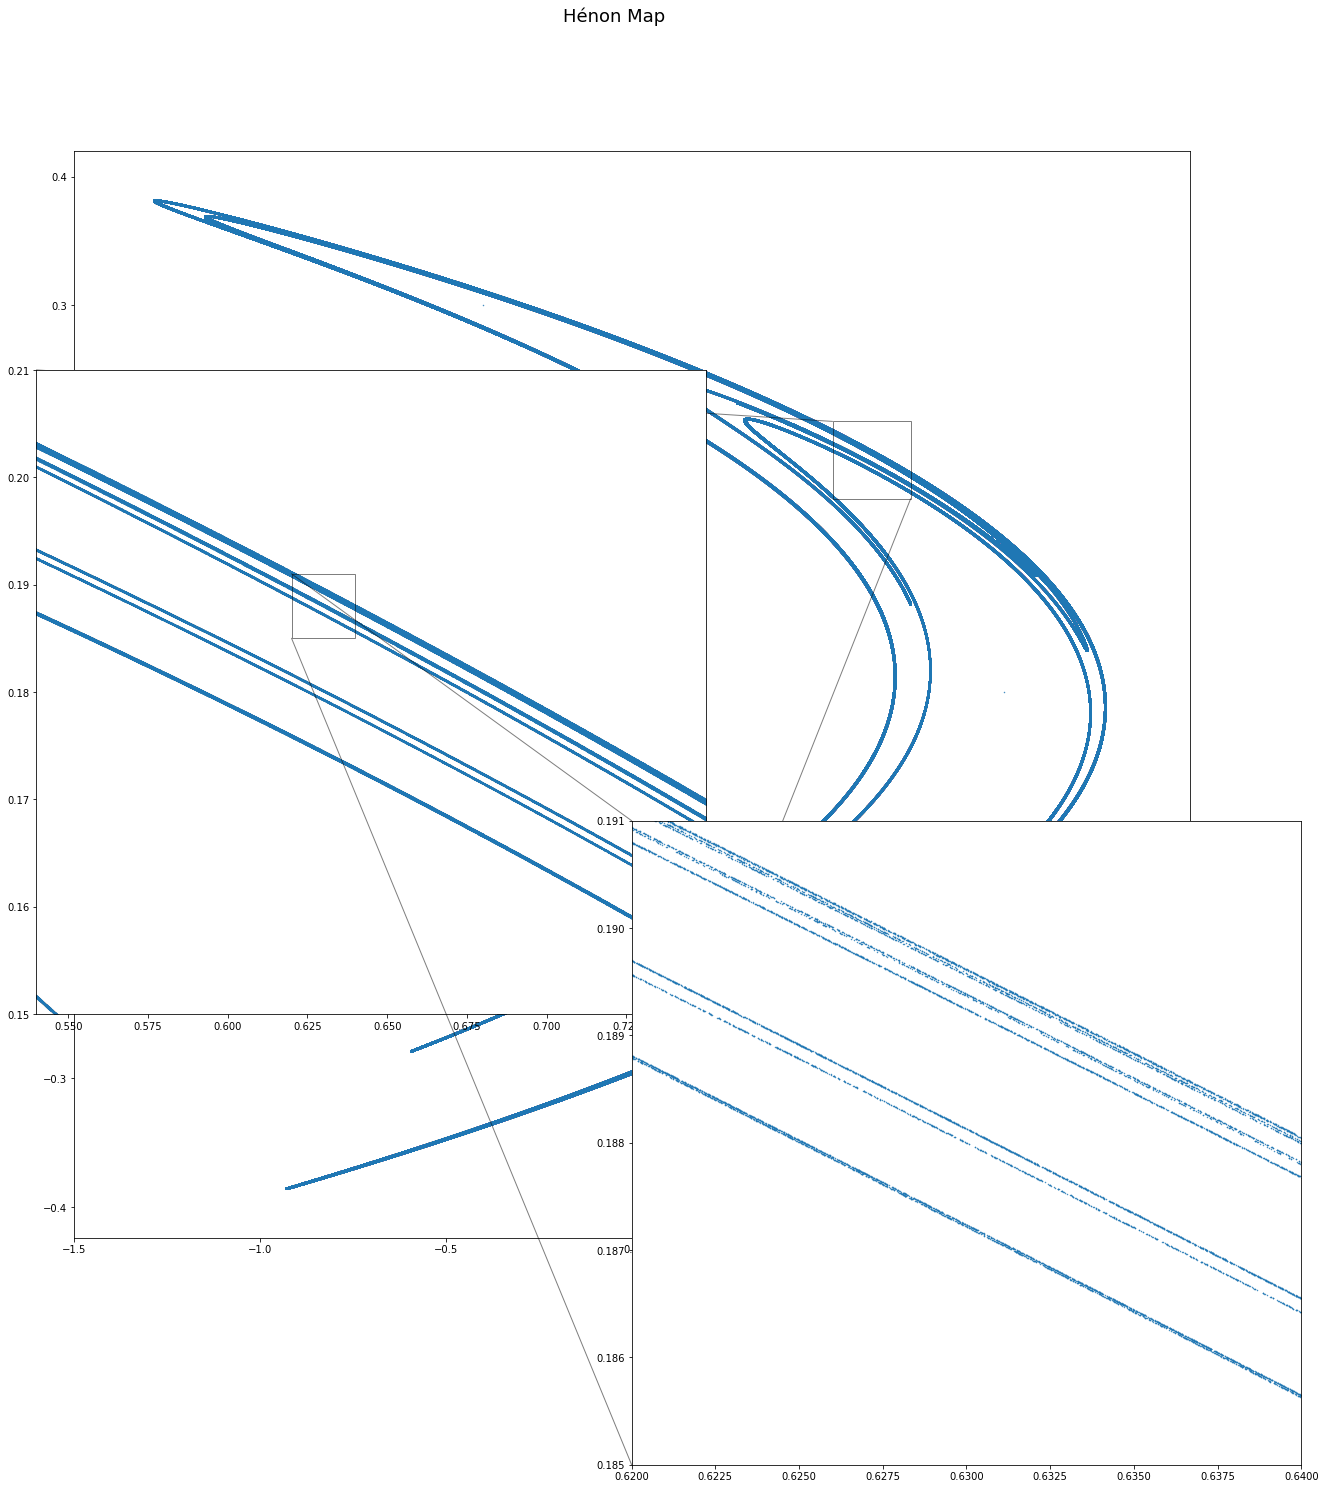

In [114]:
def henon_map(a, b):
  return lambda v: [v[1] + 1 - a * v[0]**2, b * v[0]]

points = get_iterative_map_results(henon_map(1.4, .3), [0, 0], 5_000_000)
xs, ys = np.array(points).T

fig, ax = plt.subplots(figsize=(20, 20))
fig.suptitle("Hénon Map", fontsize=18)
ax.scatter(xs, ys, s=.2)
ax.set_xlim([-1.5, 1.5])

axins = ax.inset_axes([-1.6, -.25, 1.8, .5], transform=ax.transData)

subregion = [[.54, .75], [.15, .21]]

axins.set_xlim(subregion[0])
axins.set_ylim(subregion[1])
axins.scatter(xs, ys, s=.2)
ax.indicate_inset_zoom(axins, edgecolor="black")

axins2 = axins.inset_axes([0, -.6, 1.8, .5], transform=ax.transData)
subregion = [[.62, .64], [.185, .191]]
axins2.set_xlim(subregion[0])
axins2.set_ylim(subregion[1])
axins2.scatter(xs, ys, s=.2)
axins.indicate_inset_zoom(axins2, edgecolor="black")

plt.show()

## Non-autonomous Systems

### Double Well Potential with Periodic Forcing

Consider a particle in a double well potential with position $x$ relative to a box which is being shaken with periodic forcing

$$
\ddot{x} + \delta\dot{x} + x^3 - x = F\cos(\omega t)
$$

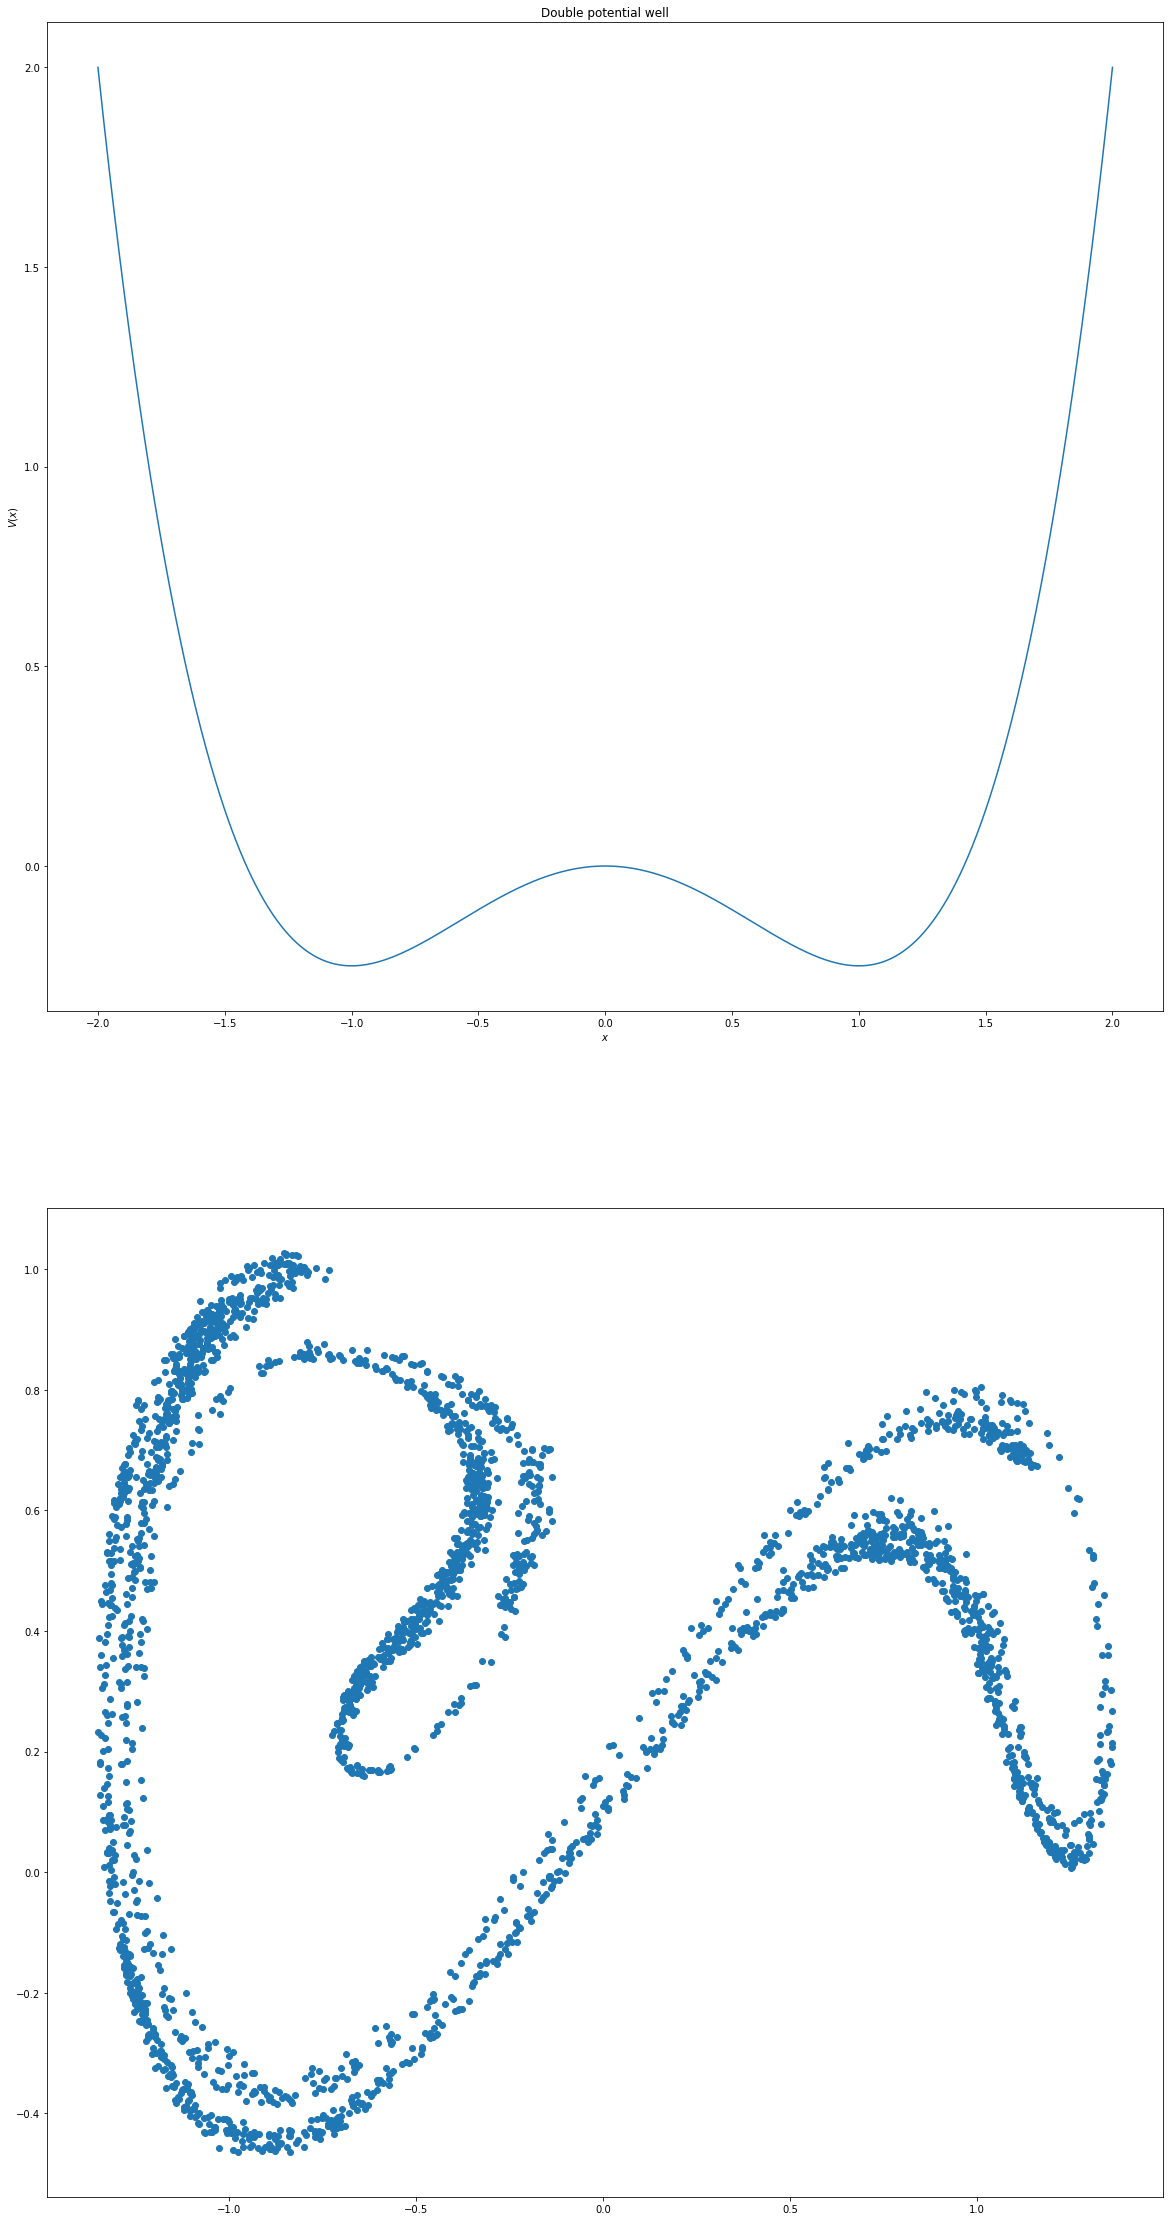

In [147]:
fig, (axA, axB) = plt.subplots(2, 1, figsize=(20, 40))

xs = np.linspace(-2, 2, 1000)
axA.plot(xs, xs**4/4 - xs**2/2)
axA.set_title("Double potential well")
axA.set_xlabel("$x$")
axA.set_ylabel("$V(x)$")

def forced_double_well_potential(delta, omega, F):
  return lambda t, y: [y[1], F * np.cos(omega * t) - delta * y[1] + y[0] - y[0] ** 3]

sol = integrate.solve_ivp(forced_double_well_potential(.25, 1, .4), [0, 20_000], [0, 0], max_step=.1)

# All points where t is an integer multiple of 2π
poincare_section_idxs = np.argwhere(sol.t[1:] % (2 * np.pi) - sol.t[:-1] % (2 * np.pi) < 0)[300:]
axB.scatter(sol.y[0][poincare_section_idxs], sol.y[1][poincare_section_idxs])

plt.show()

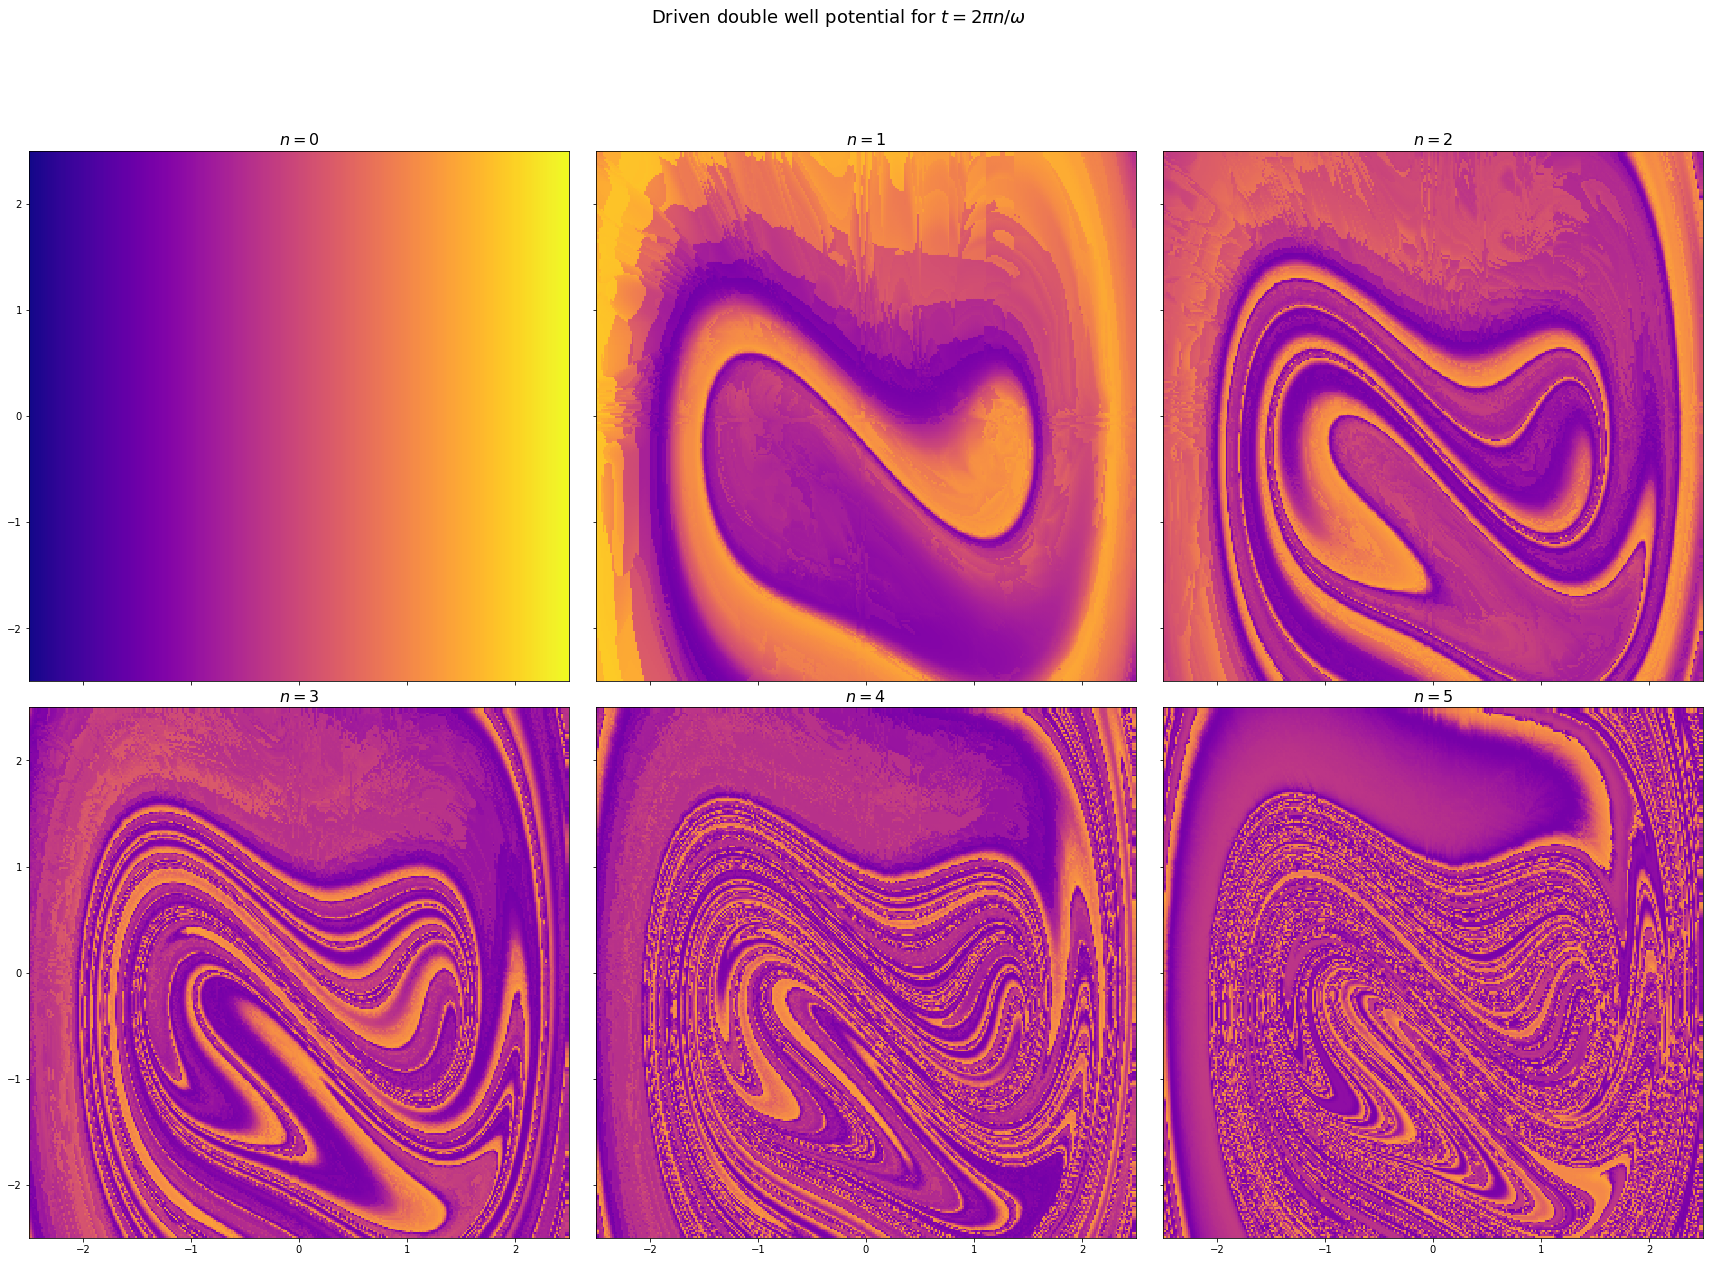

In [287]:
xs = np.linspace(-2.5, 2.5, 300)
ys = np.linspace(-2.5, 2.5, 300)
init_points = np.array([(x, y) for x in xs for y in ys])

omega = 1
fn = forced_double_well_potential(.25, omega, .4)

drive_cycle_t = 2 * np.pi / omega

sols = [
  integrate.solve_ivp(fn, [0, 5 * drive_cycle_t], [x, y])
  for x in xs for y in ys
]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, gridspec_kw=dict({"wspace": .05, "hspace": .05}), subplot_kw=dict({"xlim": [-2.5, 2.5], "ylim": [-2.5, 2.5]}), figsize=(30, 20))
fig.suptitle("Driven double well potential for $t = 2\pi n / \omega$", fontsize=18)

for n, ax in enumerate(axes.flatten(), start=0):
  sol_nth_drive_cycle = np.array([sol.y[0][np.argmin(np.abs(sol.t - n * drive_cycle_t))] for sol in sols])
  ax.set_title(f"$n = {n}$", fontsize=16)
  ax.scatter(
    init_points[:, 0],
    init_points[:, 1],
    s=67,
    marker="s",
    c=mpl.cm.plasma((sol_nth_drive_cycle + 2.5) / 5)
  )

## Exercises

### 12.1.8
Hénon's quadratic area preserving map
$$
\begin{align*}
x_{n+1} &= x_n\cos\alpha - (y_n - x_n^2)\sin\alpha \\
y_{n+1} &= x_n\sin\alpha + (y_n - x_n^2)\cos\alpha
\end{align*}
$$

The below plots show the trajectories for $(.4, .5)$ over $10^4$ iterations (LHS) and the radial distance from the origin after $10^4$ iterations (RHS) for $\cos\alpha \in \{0.24, 0.22\}$. Five "islands" are clearly shown with chaos occuring around the island in the $\cos\alpha = 0.22$ case. The radial distance plots show these islands in the form of continuous boundaries around those regions. Purple indicates that the points have remained close to the center, yellow that they have moved away from the center, and white that the trajectories have escaped to infinity. The increased noise (yellow and red dots) around the islands clearly shows the sensitive dependence on initial conditions. Note also that for $0.24$ there is a continuous bounding line that corresponds to a stable limit cycle, this is destroyed by the chaos in the $0.22$ case.

The colour plot also suggests that for some intermediate value of $\alpha$ the trajectories are heteroclinic. Outside of the limit cycle seems to be a chaotic regime, the islands become surrounded by chaos as the limit cycle tightens and then merges with the islands.

/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_62942/3305058942.py:3: RuntimeWarning: overflow encountered in double_scalars
  y[0] * np.cos(alpha) - (y[1] - y[0]**2) * np.sin(alpha),
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_62942/3305058942.py:4: RuntimeWarning: overflow encountered in double_scalars
  y[0] * np.sin(alpha) + (y[1] - y[0]**2) * np.cos(alpha)
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_62942/3305058942.py:4: RuntimeWarning: invalid value encountered in double_scalars
  y[0] * np.sin(alpha) + (y[1] - y[0]**2) * np.cos(alpha)
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_62942/3305058942.py:18: RuntimeWarning: overflow encountered in square
  axA2.scatter(init_points[:, 0], init_points[:, 1], s=25, marker="s", c=mpl.cm.plasma(np.sqrt(final_points[:, 0]**2 + final_points[:, 1]**2)))
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_62942/3305058942.py:25: RuntimeWarning: overflow encountered in square
  axB

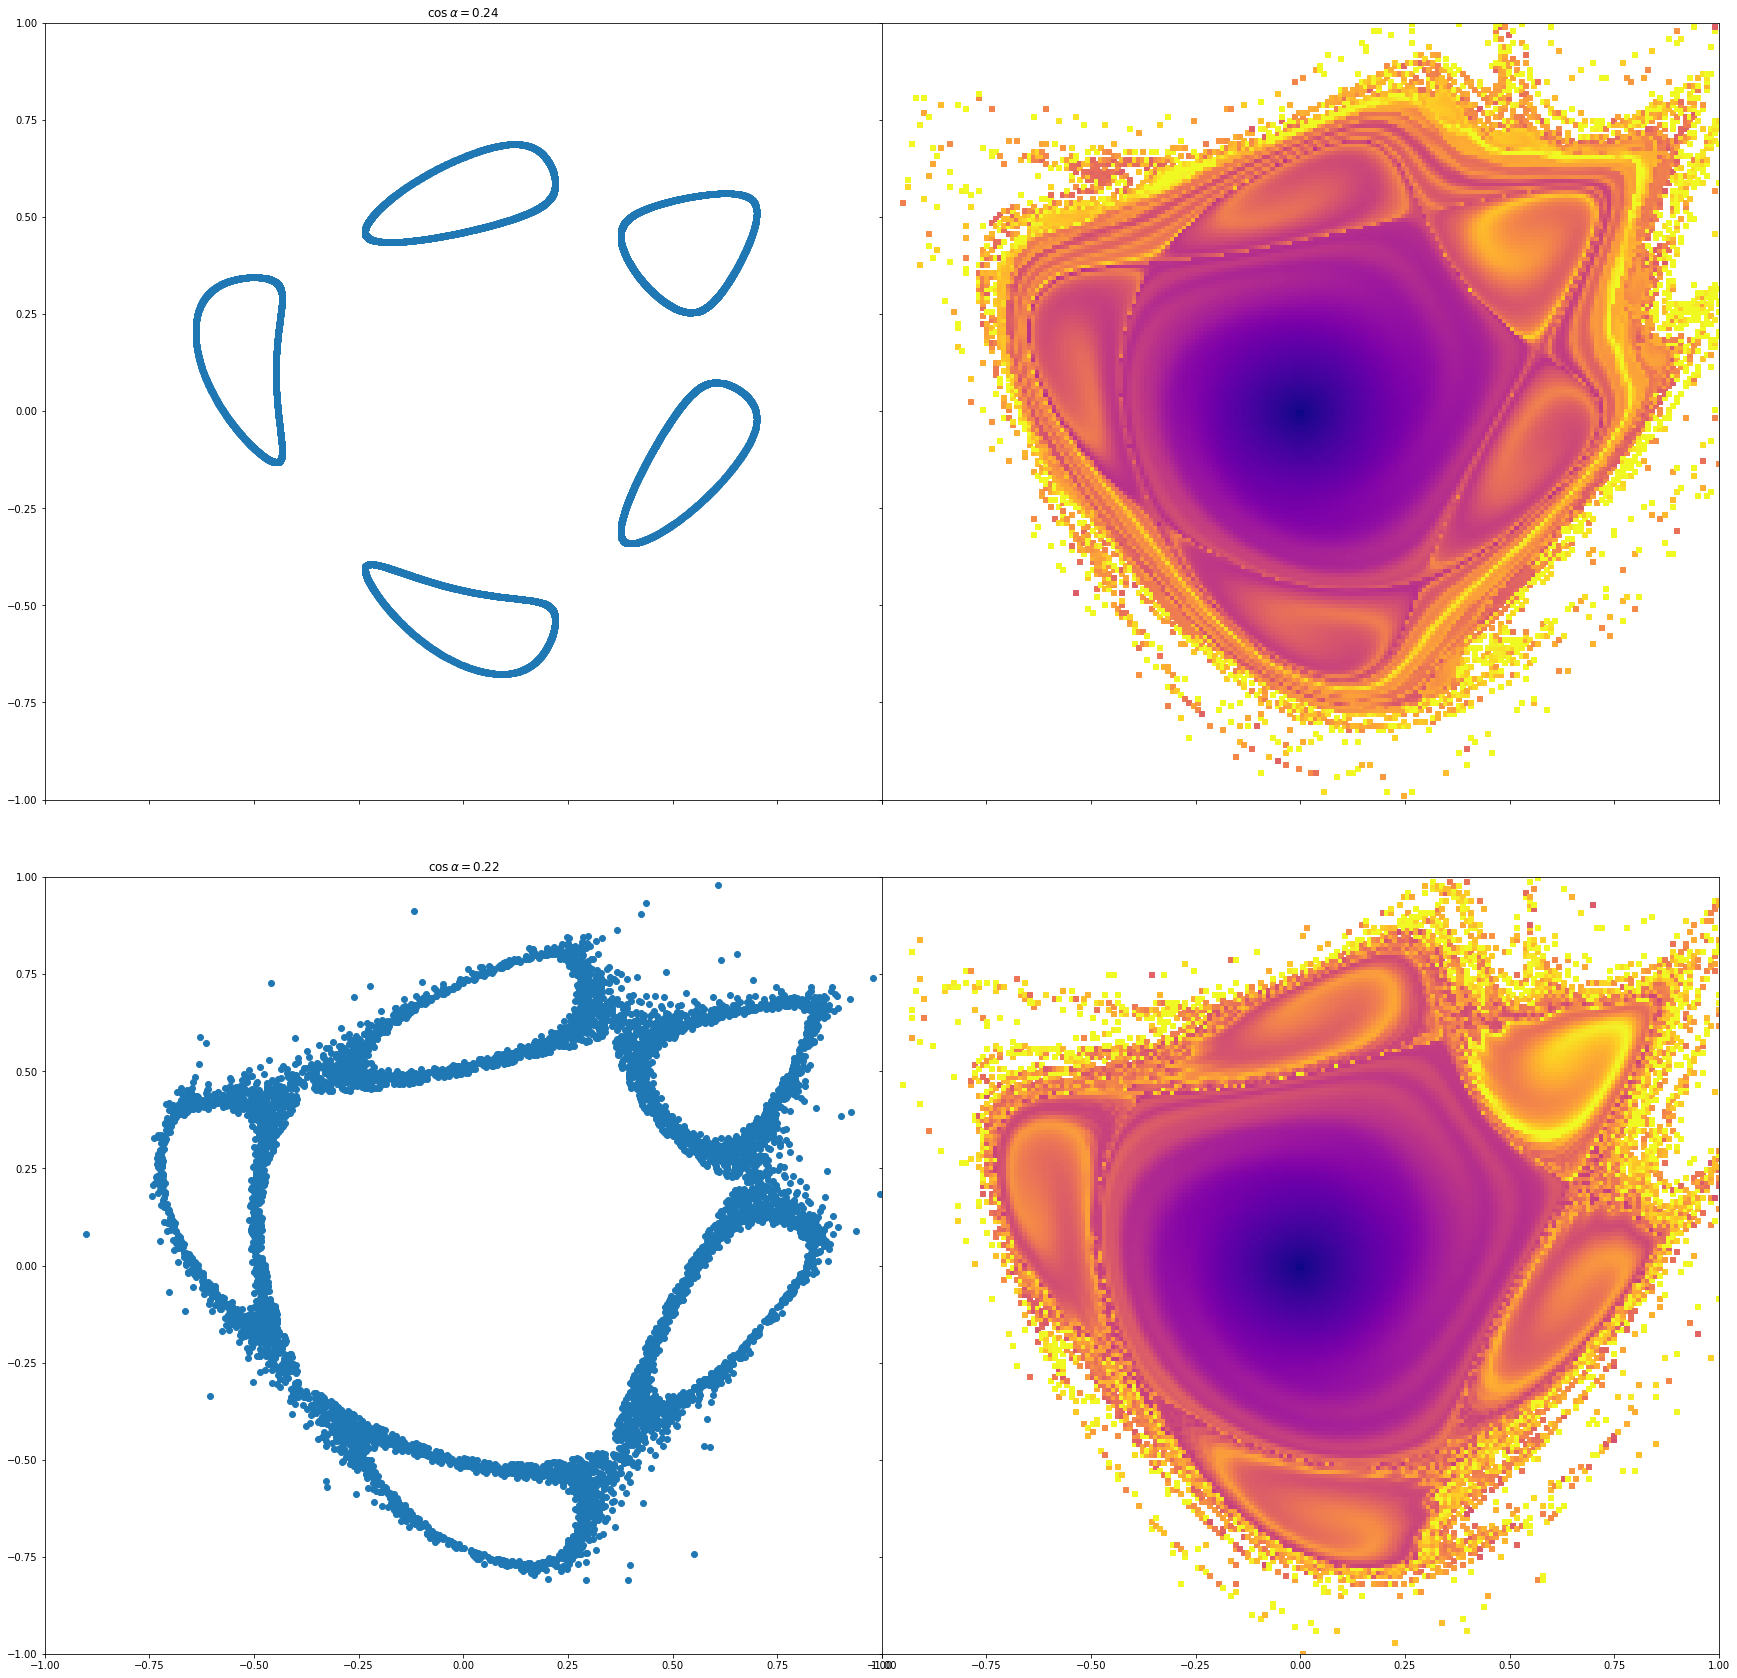

In [487]:
def henon_quad(alpha):
  return lambda y: [
    y[0] * np.cos(alpha) - (y[1] - y[0]**2) * np.sin(alpha),
    y[0] * np.sin(alpha) + (y[1] - y[0]**2) * np.cos(alpha)
  ]

xs = np.linspace(-1, 1, 200)
ys = np.linspace(-1, 1, 200)
init_points = np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2)

fig, ((axA1, axA2), (axB1, axB2)) = plt.subplots(2, 2, sharex=True, sharey=True, gridspec_kw=dict({"wspace": 0, "hspace": .1}), subplot_kw=dict({"xlim": [-1, 1], "ylim": [-1, 1]}), figsize=(30, 30))

alpha = np.arccos(.24)
sol = np.array(get_iterative_map_results(henon_quad(alpha), [.4, .5], 10_000))
axA1.scatter(sol[:, 0], sol[:, 1])
axA1.set_title("$\cos\\alpha = 0.24$")
final_points = np.array([get_iterative_map_results(henon_quad(alpha), p, 100)[-1] for p in init_points])
axA2.scatter(init_points[:, 0], init_points[:, 1], s=25, marker="s", c=mpl.cm.plasma(np.sqrt(final_points[:, 0]**2 + final_points[:, 1]**2)))

alpha = np.arccos(.22)
sol = np.array(get_iterative_map_results(henon_quad(alpha), [.4, .5], 10_000))
axB1.set_title("$\cos\\alpha = 0.22$")
axB1.scatter(sol[:, 0], sol[:, 1])
final_points = np.array([get_iterative_map_results(henon_quad(alpha), p, 100)[-1] for p in init_points])
axB2.scatter(init_points[:, 0], init_points[:, 1], s=25, marker="s", c=mpl.cm.plasma(np.sqrt(final_points[:, 0]**2 + final_points[:, 1]**2)))
plt.show()

### 12.1.9
The standard map
$$
\begin{align*}
x_{n+1} &= x_n + y_{n+1} \\
y_{n+1} &= y_n + k\sin x_n
\end{align*}
$$
Where $x_n, y_n$ are modulo $2\pi$

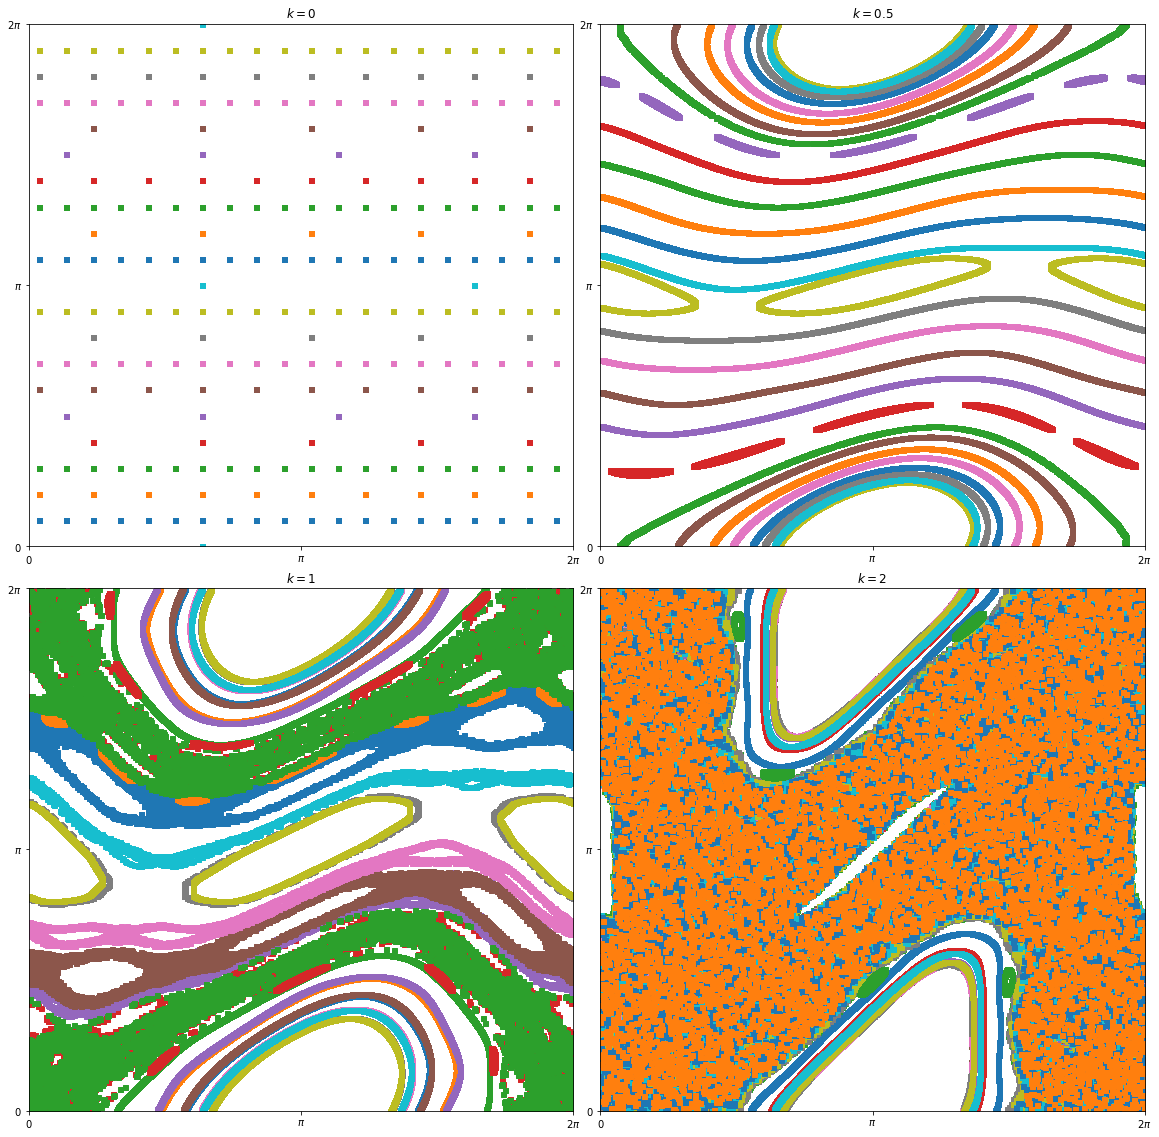

In [489]:
def standard_map(k):
  return lambda y: [
    (y[0] + y[1] + k * np.sin(y[0])) % (2 * np.pi),
    (y[1] + k * np.sin(y[0])) % (2 * np.pi),
  ]

fig, axes = plt.subplots(
  2,
  2,
  gridspec_kw=dict({
    "hspace": .08,
    "wspace": .05,
  }),
  subplot_kw=dict({
    "xlim": [0, 2 * np.pi],
    "ylim": [0, 2 * np.pi],
    "xticks": [0, np.pi, 2 * np.pi],
    "yticks": [0, np.pi, 2 * np.pi],
    "xticklabels": ["$0$", "$\pi$", "$2\pi$"],
    "yticklabels": ["$0$", "$\pi$", "$2\pi$"],
  }),
  figsize=(20, 20),
)

ks = [0, .5, 1, 2]
for idx, ax in enumerate(axes.flatten()):
  ax.set_title(f"$k = {ks[idx]}$")
  for n in range(1, 21):
    p = [2, np.pi * n / 10]
    sol = np.array(get_iterative_map_results(standard_map(ks[idx]), p, 10_000))
    ax.scatter(sol[:, 0], sol[:, 1], s=25, marker="s")

plt.show()

### 12.2.8
The Hénon map for $b=0.3$ has a period-2 orbit at $a = 0.9$, a period-4 orbit at $a = 1$, a period-8 orbit at $a = 1.03$ and chaos at $a = 1.06$, thus there is a period doubling route to chaos. For $a = 1.3$ there is a periodic window (of period-7).

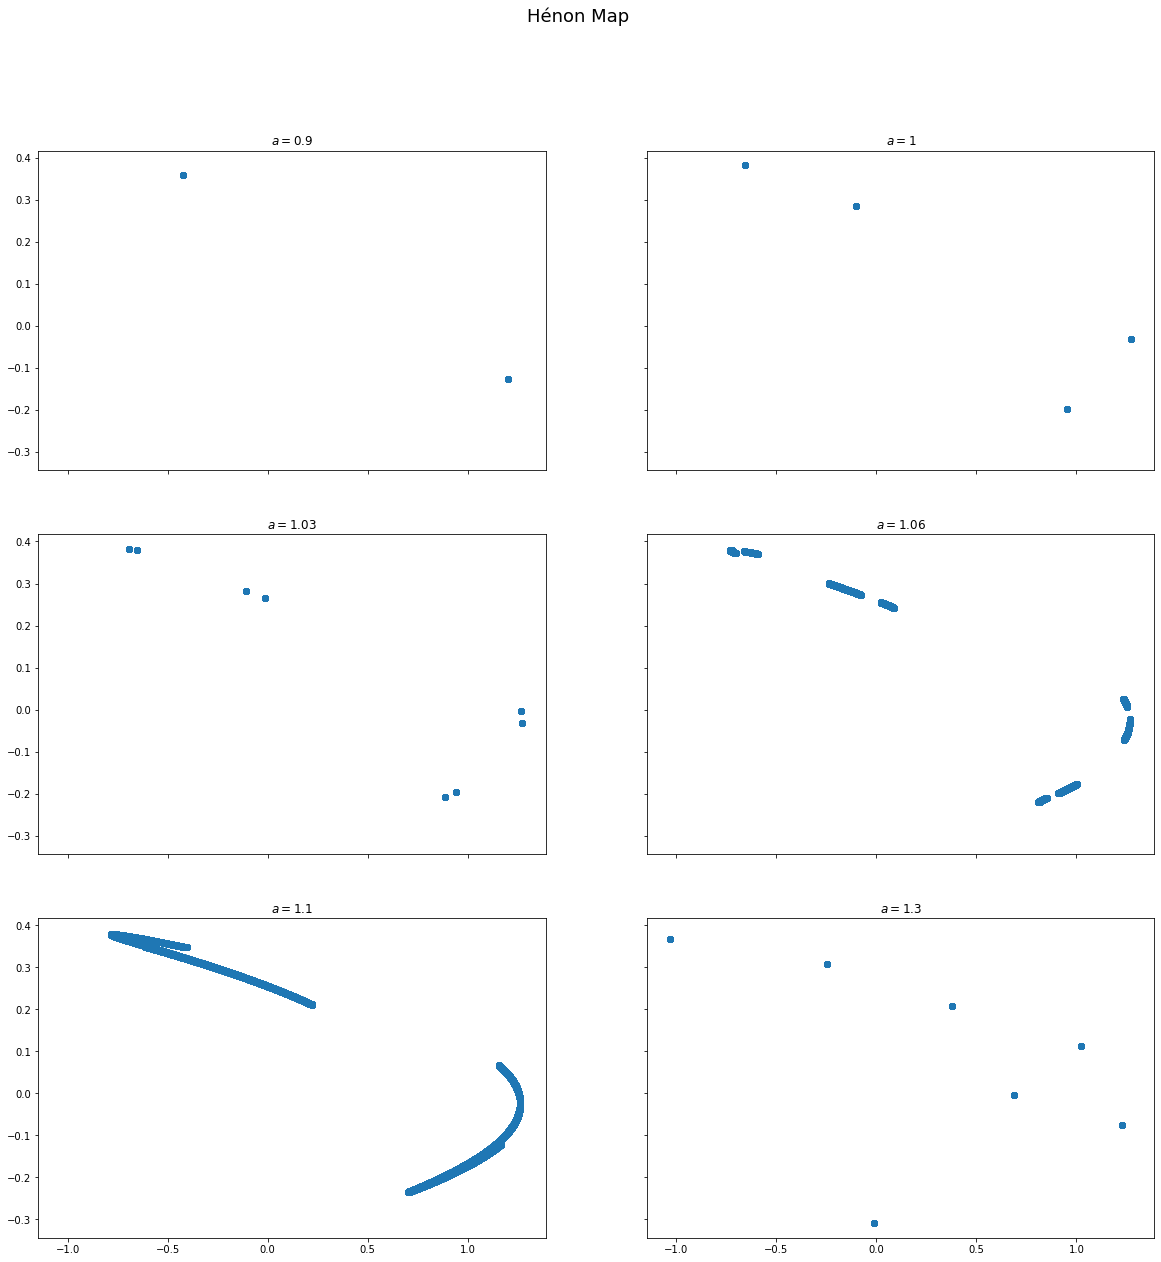

In [512]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle("Hénon Map", fontsize=18)

a_vals = [.9, 1, 1.03, 1.06, 1.1, 1.3]
for idx, ax in enumerate(axes.flatten()):
  points = get_iterative_map_results(henon_map(a_vals[idx], .3), [0, 0], 50_000)[300:]
  xs, ys = np.array(points).T

  ax.scatter(xs, ys)
  ax.set_title(f"$a = {a_vals[idx]}$")

### 12.2.9
Let $T$ be the Hénon map for $a = 1.4, b = 0.3$, consider the quadilateral $Q$ defined by the points $(-1.33, 0.42), (1.32, 0.133), (1.245, -0.14), (-1.06, -0.5)$

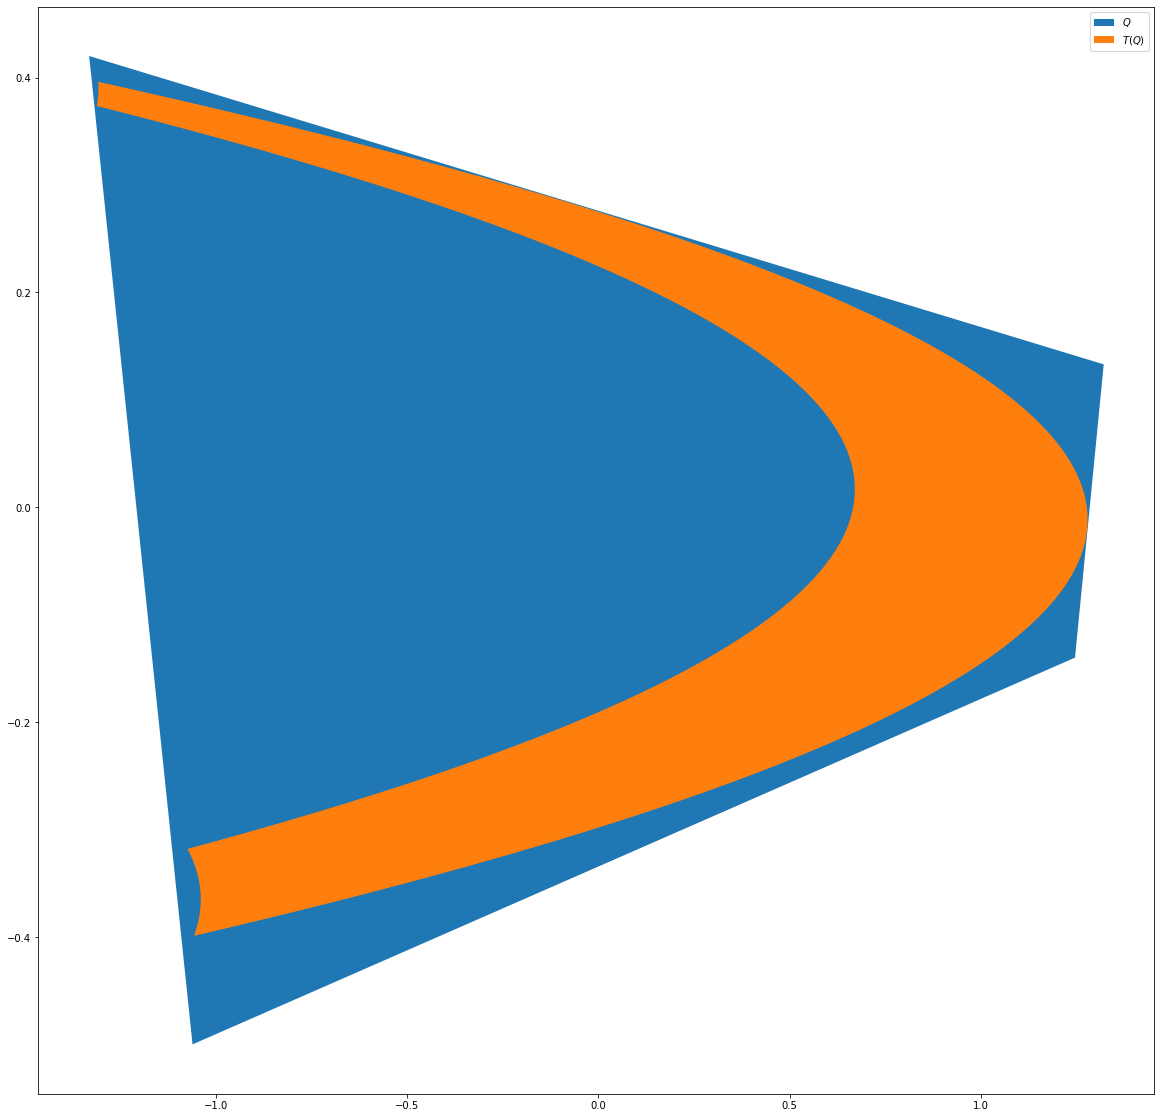

In [566]:
ts = np.linspace(0, 1, 100)

def gen_parametric_line_segment(start, end):
  return np.array([[start[0] + (end[0] - start[0]) * t, start[1] + (end[1] - start[1]) * t] for t in ts])

q_1 = gen_parametric_line_segment([-1.33, .42], [1.32, .133])
q_2 = gen_parametric_line_segment([1.32, .133], [1.245, -.14])
q_3 = gen_parametric_line_segment([1.245, -.14], [-1.06, -.5])
q_4 = gen_parametric_line_segment([-1.06, -.5], [-1.33, .42])
points = np.concatenate((q_1, q_2, q_3, q_4))

plt.fill(points[:, 0], points[:, 1], label="$Q$")

transformed_points = np.array([henon_map(1.4, .3)(p) for p in points])
plt.fill(transformed_points[:, 0], transformed_points[:, 1], label="$T(Q)$")

plt.legend()

### 12.4.2
$$
x(t) = 3\sin t + \sin(\sqrt{2} t)
$$

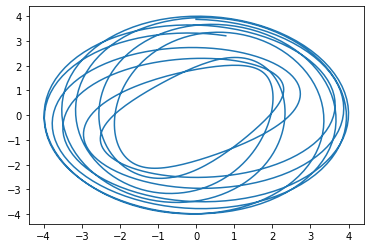

In [25]:
omega = np.pi
tau = .45 * np.pi
ts = np.linspace(0, 20 * np.pi, 1000)

def fn(t):
  return 3 * np.sin(t) + np.sin(np.sqrt(2) * t)

plt.plot(fn(ts), fn(ts + tau))

plt.show()

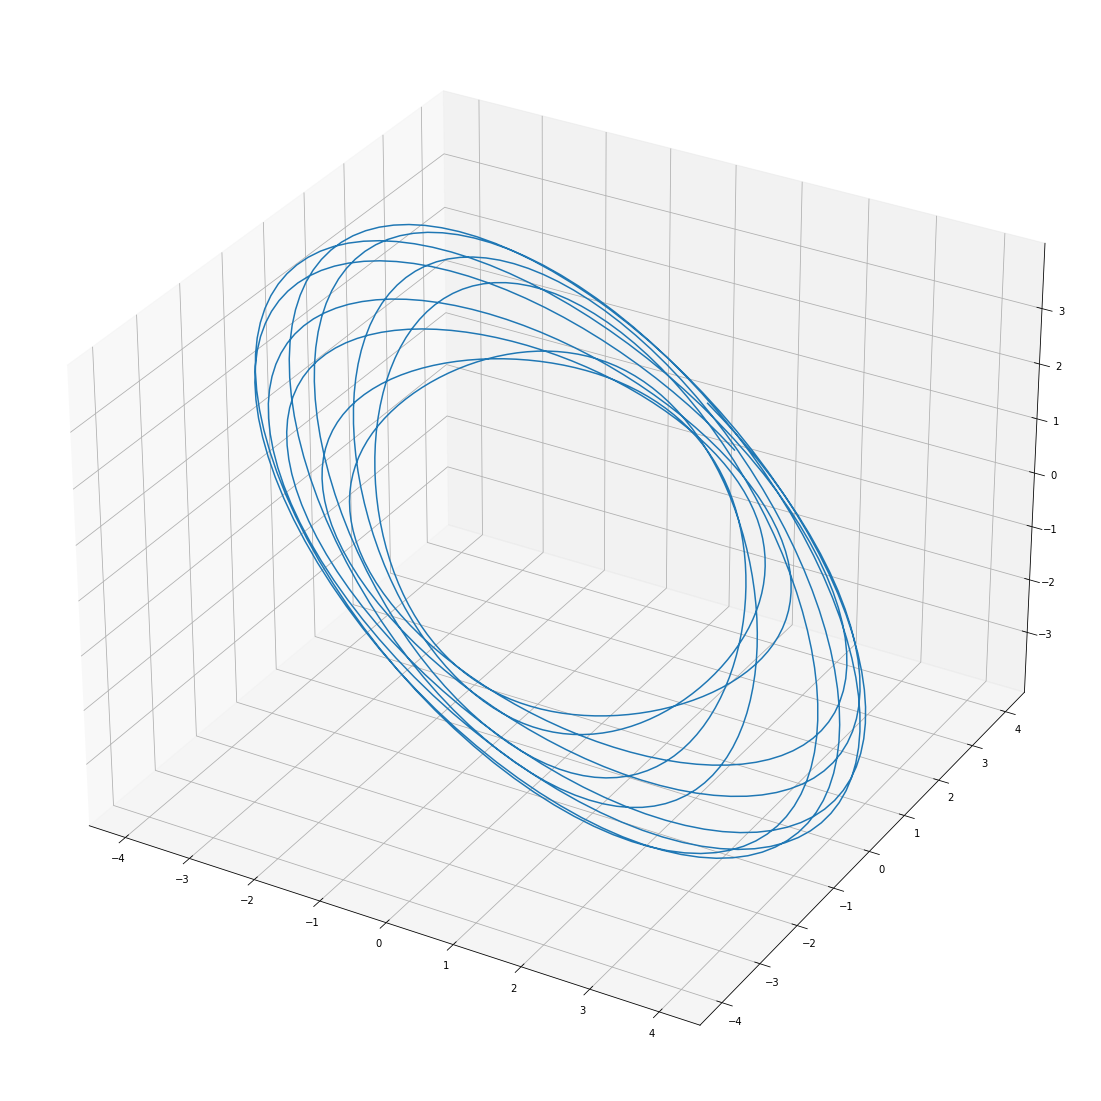

In [28]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(projection="3d")

tau = .45 * np.pi
plt.plot(fn(ts), fn(ts + tau), fn(ts + 2 * tau))

plt.show()

### 12.4.3
Rössler system
$$
\begin{align*}
\dot{x} &= -y - z \\
\dot{y} &= x + ay \\
\dot{z} &= b + z(x - c)
\end{align*}
$$

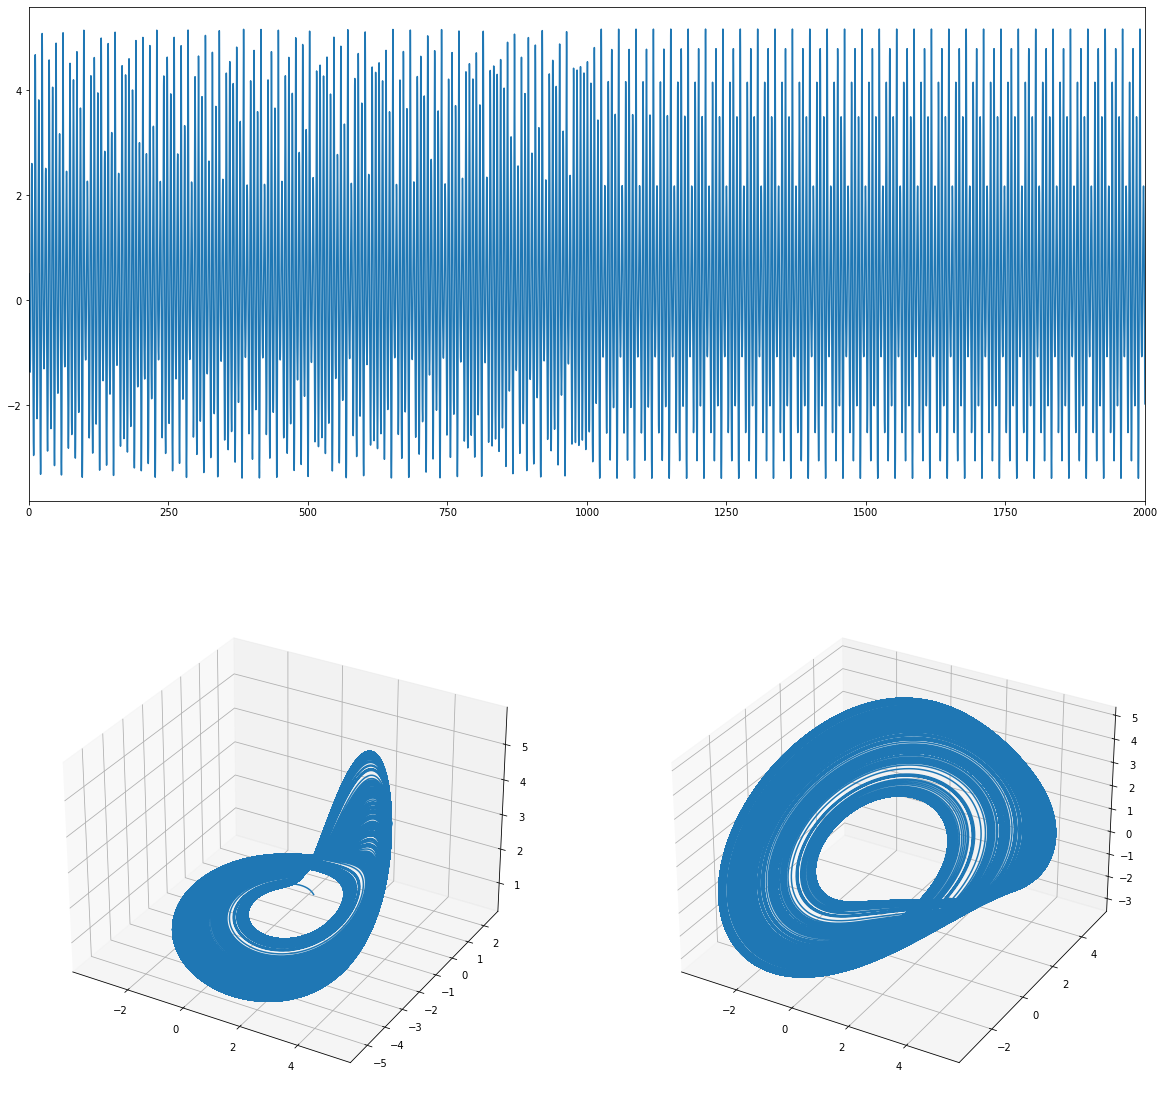

In [83]:
def rossler(a, b, c):
  return lambda t, y: [-y[1] - y[2], y[0] + a * y[1], b + y[2] * (y[0] - c)]

sol = integrate.solve_ivp(rossler(.4, 2, 4), [0, 2_000], [.5, .5, .5], max_step=.01)

fig = plt.figure(figsize=(20, 20))
gs = plt.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0], projection="3d")
ax3 = fig.add_subplot(gs[1, 1], projection="3d")

ax1.plot(sol.t, sol.y[0])
ax1.set_xlim([0, 2_000])

ax2.plot(*sol.y)

# tau ~ 0.8
t_idx_offset = 80
ax3.plot(sol.y[0][:-2 * t_idx_offset], sol.y[0][t_idx_offset:-t_idx_offset], sol.y[0][2 * t_idx_offset:])

plt.show()